# FIAP Bootcamp - Wtec Suprimentos - Classificação de Novos Clientes
Case: **Wtec Suprimentos - Análise de Crédito**\
Turma: **1IAR**

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## Introdução

### Problema Proposto - Parte 3: Classificação de Novos Clientes
- Um problema Jä mapeado é o que fazer apos a geracäo desses grupos quando chegar um novo cliente solicitando um novo crédito?
- Como seria possivel indicar o grupo desse cliente sem ter que refazer todos os grupos?

### Abordagem Proposta
- O objetivo desta modelagem é treinar um algoritmo de aprendizado capaz de classificar automaticamente novos clientes com base na segmentação atualmente existente
- Será utilizado um algoritmo supervisionado para essa classificação, baseado nas segmentações obtidas no modelo de clusterização
- Serão explorados os dois cenários propostos até o momento, e ambos serão comparados ao final:
	- cenário 1: utilizando informações do cliente disponíveis sem a exigência das documentações contábeis
	- cenário 2: utilizando informações disponíveis nas documentações contábeis

### Setup

In [1]:
# dados / io
import pandas as pd
import pandas_flavor as pf
import numpy as np
import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# otimização
from sklearnex import patch_sklearn
patch_sklearn()
# preprocessamento
from sklearn.preprocessing import StandardScaler
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# seleção de modelos
import optuna as opt
opt.logging.set_verbosity(opt.logging.WARNING)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
# display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=opt.exceptions.ExperimentalWarning)
pd.options.display.float_format = '{:,.4f}'.format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Carga de Dados

In [2]:
data = pd.read_csv('solicitacoescredito_segmentada.csv')
data.sample(5).T

,2147,2045,106,7071,3137
numero_solicitacao,"2,220.0000","2,118.0000",112.0000,"7,144.0000","3,210.0000"
razaoSocial,Andrea Thomas,Dr. Laura Jones,Paul Smith,Sian Evans,Brenda Clarke
nomeFantasia,Elizabeth Harrison-Davis,Jeremy Savage,Dr. Hilary Abbott,Marie Chapman,Dr. Mohamed Phillips
cnpjSemTraco,HLSB25210925374623,EAHM06412905306774,HXQX28522825811324,AXJA46741304327572,APRH60376910869961
maiorAtraso,6,6,5,20,36
margemBrutaAcumulada,0.3538,0.6047,0.2891,0.2964,0.5048
percentualProtestos,0.0000,0.0000,0.0000,0.0000,0.0000
primeiraCompra,2017-06-14T00:00:00,2013-12-04T00:00:00,2012-12-13T00:00:00,2017-03-20T00:00:00,2011-10-14T00:00:00
prazoMedioRecebimentoVendas,68,0,0,0,48
titulosEmAberto,"31,876.9000",0.0000,0.0000,0.0000,"95,983.7400"


### Pre-Processamento

#### filtro

In [3]:
# filtra as solicitações aprovadas
@pf.register_dataframe_method
def filter_status(
	data: pd.DataFrame, # dataframe com a coluna 'status'
	) -> pd.DataFrame:
	X = data.copy()
	X = X[X.status.isin(['AprovadoAnalista', 'AprovadoComite'])]
	X = X[X.anoFundacao > 1900]
	X = X[X.faturamentoBruto > 0]
	X = X[X.periodoDemonstrativoEmMeses > 0]
	return X
data.filter_status().describe().T

,count,mean,std,min,25%,50%,75%,max
numero_solicitacao,"7,201.0000","4,562.6327","2,601.4811",1.0000,"2,353.0000","4,585.0000","6,827.0000","9,034.0000"
maiorAtraso,"7,201.0000",24.3693,64.0252,0.0000,3.0000,6.0000,22.0000,977.0000
margemBrutaAcumulada,"7,201.0000",0.3669,0.1982,0.0000,0.2916,0.4066,0.5083,1.0000
percentualProtestos,"6,057.0000",0.0149,0.5618,0.0000,0.0000,0.0000,0.0000,36.9837
prazoMedioRecebimentoVendas,"7,201.0000",24.1857,71.0564,0.0000,0.0000,0.0000,32.0000,"1,605.0000"
titulosEmAberto,"7,201.0000","61,165.5448","216,805.2221",0.0000,0.0000,0.0000,"18,605.3000","2,836,656.0000"
valorSolicitado,"7,201.0000","480,475.4699","15,912,896.0448","3,000.0000","25,000.0000","50,000.0000","130,000.0000","1,200,000,000.0000"
diferencaPercentualRisco,"7,201.0000",0.7402,0.1255,0.2642,0.6429,0.7500,0.8491,1.0000
percentualRisco,"7,201.0000",0.2598,0.1255,0.0000,0.1509,0.2500,0.3571,0.7358
dashboardCorrelacao,"7,201.0000",0.0429,0.4955,-1.0000,0.0000,0.0000,0.0000,1.0000


#### feature engineering

In [4]:
# gera as features calculadas sem usar as colunas de documentação
@pf.register_dataframe_method
def engineer(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['faturamentoMensal'] = X.faturamentoBruto / X.periodoDemonstrativoEmMeses
	X['margemMensal'] = X.margemBruta / X.periodoDemonstrativoEmMeses
	X['margem_percentual'] = (X.margemMensal / X.faturamentoMensal).replace([np.inf, np.NINF], np.nan)
	X['dt_dataAprovadoNivelAnalista'] = pd.to_datetime(X.dataAprovadoNivelAnalista, errors='coerce')
	X['dt_primeiraCompra'] = pd.to_datetime(X.primeiraCompra, errors='coerce')
	X['tempoPrimeiraCompra'] = (X.dt_dataAprovadoNivelAnalista - X.dt_primeiraCompra).dt.days
	return X

data.filter_status().engineer().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   numero_solicitacao            7201 non-null   float64       
 1   razaoSocial                   7201 non-null   object        
 2   nomeFantasia                  7201 non-null   object        
 3   cnpjSemTraco                  7201 non-null   object        
 4   maiorAtraso                   7201 non-null   int64         
 5   margemBrutaAcumulada          7201 non-null   float64       
 6   percentualProtestos           6057 non-null   float64       
 7   primeiraCompra                7159 non-null   object        
 8   prazoMedioRecebimentoVendas   7201 non-null   int64         
 9   titulosEmAberto               7201 non-null   float64       
 10  valorSolicitado               7201 non-null   float64       
 11  status                        

#### seleção de features

In [5]:
# seleciona as features relevantes
@pf.register_dataframe_method
def select(
  data: pd.DataFrame,
  identifier: bool = False,
) -> pd.DataFrame:
	keep = [
			# 'percentualRisco',
			# 'valorAprovado',
			# 'limiteEmpresaAnaliseCredito',
			# 'limiteCredito',
			'faturamentoMensal',
			'maiorAtraso',
			'tempoPrimeiraCompra',
			'prazoMedioRecebimentoVendas',
			'anoFundacao',
			'restricoes',
			'empresa_MeEppMei',
			'scorePontualidade',
			'margem_percentual',
			'cluster',
		]
	if identifier:
		keep = keep + ['numero_solicitacao']
	intersection = list(set(data.columns).intersection(set(keep)))
	return data[intersection]
data.filter_status().engineer().select().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   restricoes                   7201 non-null   object 
 1   margem_percentual            7201 non-null   float64
 2   empresa_MeEppMei             7201 non-null   object 
 3   tempoPrimeiraCompra          6631 non-null   float64
 4   scorePontualidade            7201 non-null   float64
 5   prazoMedioRecebimentoVendas  7201 non-null   int64  
 6   cluster                      6631 non-null   float64
 7   maiorAtraso                  7201 non-null   int64  
 8   anoFundacao                  7201 non-null   float64
 9   faturamentoMensal            7201 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 618.8+ KB


#### data types

In [6]:
# converte data types
@pf.register_dataframe_method
def type_cast(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X = X.astype('float32')
	return X
data.filter_status().engineer().select().type_cast().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7201 entries, 0 to 8961
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   restricoes                   7201 non-null   float32
 1   margem_percentual            7201 non-null   float32
 2   empresa_MeEppMei             7201 non-null   float32
 3   tempoPrimeiraCompra          6631 non-null   float32
 4   scorePontualidade            7201 non-null   float32
 5   prazoMedioRecebimentoVendas  7201 non-null   float32
 6   cluster                      6631 non-null   float32
 7   maiorAtraso                  7201 non-null   float32
 8   anoFundacao                  7201 non-null   float32
 9   faturamentoMensal            7201 non-null   float32
dtypes: float32(10)
memory usage: 337.5 KB


#### limpeza

In [7]:
# elimina valores nulos
@pf.register_dataframe_method
def clean(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.dropna()
data.filter_status().engineer().select().type_cast().clean().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   restricoes                   6631 non-null   float32
 1   margem_percentual            6631 non-null   float32
 2   empresa_MeEppMei             6631 non-null   float32
 3   tempoPrimeiraCompra          6631 non-null   float32
 4   scorePontualidade            6631 non-null   float32
 5   prazoMedioRecebimentoVendas  6631 non-null   float32
 6   cluster                      6631 non-null   float32
 7   maiorAtraso                  6631 non-null   float32
 8   anoFundacao                  6631 non-null   float32
 9   faturamentoMensal            6631 non-null   float32
dtypes: float32(10)
memory usage: 310.8 KB


#### padronização

In [8]:
# aplica padronização por z-score
@pf.register_dataframe_method
def standardize(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	# clip outliers
	X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)
	standardizer = StandardScaler()
	X = pd.DataFrame(standardizer.fit_transform(X), columns=X.columns)
	return X
data.filter_status().engineer().select().type_cast().clean().standardize().describe().T

,count,mean,std,min,25%,50%,75%,max
restricoes,"6,631.0000",0.0000,1.0001,-0.2438,-0.2438,-0.2438,-0.2438,4.1019
margem_percentual,"6,631.0000",-0.0000,1.0001,-0.8106,-0.8106,-0.8106,0.6858,2.9826
empresa_MeEppMei,"6,631.0000",0.0000,1.0001,-0.7777,-0.7777,-0.7777,1.2859,1.2859
tempoPrimeiraCompra,"6,631.0000",-0.0000,1.0001,-1.1870,-0.7795,-0.3123,0.5899,2.4259
scorePontualidade,"6,631.0000",-0.0000,1.0001,-2.2904,0.2915,0.4953,0.4953,0.4953
prazoMedioRecebimentoVendas,"6,631.0000",-0.0000,1.0001,-0.5146,-0.5146,-0.5146,0.2597,5.1965
cluster,"6,631.0000",-0.0000,1.0001,-0.8121,-0.8121,-0.8121,0.4439,2.3280
maiorAtraso,"6,631.0000",0.0000,1.0001,-0.5172,-0.4447,-0.3723,-0.0103,6.2164
anoFundacao,"6,631.0000",0.0000,1.0001,-3.4070,-0.5660,0.2588,0.8087,1.1752
faturamentoMensal,"6,631.0000",-0.0000,1.0001,-0.2770,-0.2675,-0.2507,-0.1553,7.9016


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- foram testados 3 algoritmos diferentes de classificação<br>
- para cada algoritmo, foram testadas as principais variações dos seus hiperparâmetros<br>
- a busca foi feita por otimização bayesiana, utilizando validação cruzada com 5 partições <br>
- todas as métricas de avaliação foram feitas no conjunto de teste (holdout) <br>
- o particionamento do conjunto de teste foi feito com 20% dos registros disponíveis
</td></tr></table></div>

#### preprocessamento

In [9]:
data_preprocess = data.filter_status().engineer().select().type_cast().clean().copy()
targets_preprocess = data_preprocess['cluster']
features_preprocess = data_preprocess.drop(columns=['cluster']).standardize()

data_train, data_test, targets_train, targets_test = train_test_split(features_preprocess, targets_preprocess, test_size=0.2, random_state=42)

display(data_train.describe().T)
display(targets_train.value_counts())

,count,mean,std,min,25%,50%,75%,max
restricoes,"5,304.0000",-0.0021,0.9960,-0.2438,-0.2438,-0.2438,-0.2438,4.1019
margem_percentual,"5,304.0000",0.0088,1.0057,-0.8106,-0.8106,-0.8106,0.6856,2.9826
empresa_MeEppMei,"5,304.0000",-0.0144,0.9963,-0.7777,-0.7777,-0.7777,1.2859,1.2859
tempoPrimeiraCompra,"5,304.0000",0.0078,1.0060,-1.1870,-0.7808,-0.3096,0.6094,2.4259
scorePontualidade,"5,304.0000",0.0064,0.9937,-2.2904,0.3130,0.4953,0.4953,0.4953
prazoMedioRecebimentoVendas,"5,304.0000",0.0048,1.0025,-0.5146,-0.5146,-0.5146,0.2597,5.1965
maiorAtraso,"5,304.0000",0.0010,0.9966,-0.5172,-0.4447,-0.3723,-0.0103,6.2164
anoFundacao,"5,304.0000",-0.0059,1.0067,-3.4070,-0.5660,0.2588,0.8087,1.1752
faturamentoMensal,"5,304.0000",0.0152,1.0483,-0.2770,-0.2675,-0.2507,-0.1530,7.9016


0.0000    2714
2.0000    1567
5.0000     428
1.0000     289
4.0000     288
3.0000      18
Name: cluster, dtype: int64

### Treinamento

#### rotinas de otimização

In [10]:
# callback para salvar o melhor modelo
def callback(
		study: opt.study.Study,
		trial: opt.trial.FrozenTrial,
	) -> None:
	if study.best_trial.number == trial.number:
		study.set_user_attr(key="best_estimator", value=trial.user_attrs["estimator"])

In [11]:
# plota os resultados da otimização e a avaliação do melhor modelo no dataset de teste
def plot_optimization_results(
		study: opt.study.Study,
		y_test: pd.DataFrame,
		y_pred: np.ndarray,
	) -> None:

	# plota os resultados da otimização
	display(opt.visualization.plot_optimization_history(study))
	try:
		display(opt.visualization.plot_param_importances(study))
	except:
		...
	
	# exibe os resultados
	# results = study.trials_dataframe()
	# results = results.drop(columns=['datetime_start', # 'user_attrs_best_estimator',
	# 	'datetime_complete', 'duration', 'state'])
	# display(results.head(10))

	# imprime o melhor modelo
	print (f'Best trial: {study.best_trial.value}')
	print (f'Best parameters: {study.best_params}')

	# matriz de confusão
	print(classification_report(y_test, y_pred))
	disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))#, display_labels=fit.classes_)
	disp.plot()
	plt.show()
	
	# curva ROC
	# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
	# roc_auc = auc(fpr, tpr)
	# disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) #, estimator_name='example estimator')
	# display.plot()


In [12]:
# rotina de otimização bayesiana
def optimize(
		objective, #Callable,
    description: str,
    n_trials: int,
		X: pd.DataFrame,
		y: pd.DataFrame,
		X_test: pd.DataFrame,
		y_test: pd.DataFrame,
	) -> dict: 
        
	# cria o estudo e executa a otimização
	study = opt.create_study(direction='maximize')
	study.optimize(lambda trial:objective(trial, X, y),
		callbacks=[callback], n_trials=n_trials, timeout=60*5, n_jobs=-1, show_progress_bar = True)

	# fita e salva o melhor modelo
	fit = study.user_attrs["best_estimator"].fit(X, y)
	joblib.dump(fit, f'models/{description}.joblib')

	# avalia os resultados no conjunto de teste
	y_pred = fit.predict(X_test)

	# plota os resultados
	plot_optimization_results(study, y_test, y_pred)
	
	return {
		'description': description,
		'estimator': fit,
		'results': study.trials_dataframe(),
		'predictions': y_pred,
	}


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
foi necessário utilizar pesos para lidar com o desequilibrio das classes
</td></tr></table></div>

#### regressão logística

  0%|          | 0/39 [00:00<?, ?it/s]

Best trial: 0.9939667099390039
Best parameters: {'C': 10.163889097905809, 'l1_ratio': 0.665049354160172, 'fit_intercept': True}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       638
         1.0       1.00      1.00      1.00        77
         2.0       1.00      0.99      0.99       411
         3.0       0.62      1.00      0.77         5
         4.0       1.00      1.00      1.00        88
         5.0       0.99      1.00      1.00       108

    accuracy                           0.99      1327
   macro avg       0.93      1.00      0.96      1327
weighted avg       1.00      0.99      0.99      1327



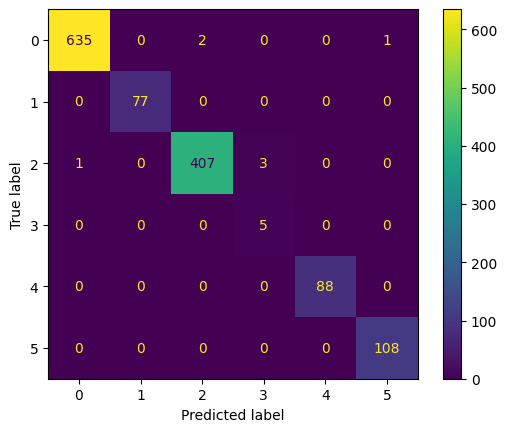

In [13]:
# define o espaço de busca e a função objetivo
def objective_logistic_regression(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = LogisticRegression(
		penalty = 'elasticnet', solver='saga',
		class_weight='balanced', # equilibra as classes
		C=trial.suggest_float('C', 1e-10, 1e+10, log=True),
		l1_ratio=trial.suggest_float('l1_ratio', 0, 1),
		fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
	)
	trial.set_user_attr(key="estimator", value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='accuracy')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
logistic_regression_model = optimize(
	objective=objective_logistic_regression, 
	description='logistic_regression', n_trials=39,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

#### árvore de decisão

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0.9717174968434905
Best parameters: {'criterion': 'gini', 'min_samples_split': 0.024, 'min_samples_leaf': 0.01}
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       638
         1.0       1.00      0.69      0.82        77
         2.0       0.93      1.00      0.96       411
         3.0       0.00      0.00      0.00         5
         4.0       0.95      1.00      0.97        88
         5.0       0.98      0.98      0.98       108

    accuracy                           0.97      1327
   macro avg       0.81      0.78      0.79      1327
weighted avg       0.97      0.97      0.97      1327



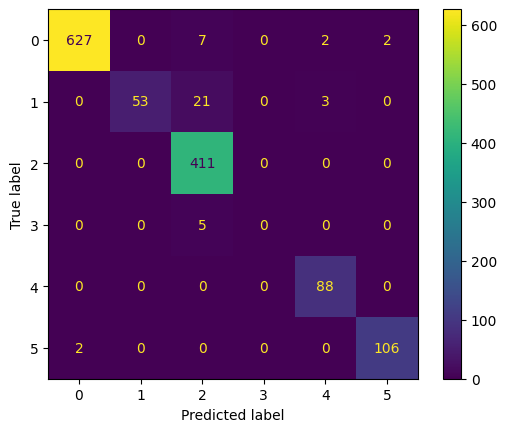

In [14]:
# define o espaço de busca e a função objetivo
def objective_decision_tree(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:	
	estimator = DecisionTreeClassifier(
		criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
		min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.4, log=False, step=0.001),
		min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.2, log=False, step=0.001),
	)
	trial.set_user_attr(key="estimator", value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='accuracy')
	return score.mean()

# rotina de otimização bayesiana
decision_tree_model = optimize(
	objective=objective_decision_tree, 
	description='decision_tree_classifier', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

#### naive bayes

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0.9934010278661998
Best parameters: {'var_smoothing': 0.05708832353748626}
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       638
         1.0       1.00      1.00      1.00        77
         2.0       0.99      1.00      0.99       411
         3.0       1.00      1.00      1.00         5
         4.0       0.99      1.00      0.99        88
         5.0       0.99      1.00      1.00       108

    accuracy                           0.99      1327
   macro avg       0.99      1.00      1.00      1327
weighted avg       0.99      0.99      0.99      1327



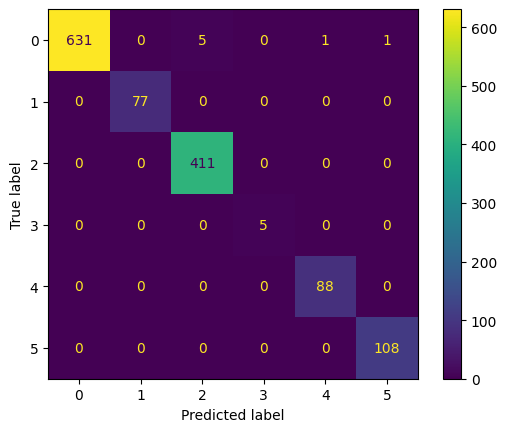

In [15]:
# define o espaço de busca e a função objetivo
def objective_naive_bayes(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:	
	estimator = GaussianNB(
		var_smoothing = trial.suggest_float('var_smoothing', 1e-15, 1, log=True),
	)
	trial.set_user_attr(key="estimator", value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='accuracy')
	return score.mean()

# rotina de otimização bayesiana
naive_bayes_model = optimize(
	objective=objective_naive_bayes, 
	description='naive_bayes_classifier', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

#### comparação de modelos

In [16]:
models = [logistic_regression_model, decision_tree_model, naive_bayes_model]
for model in models:
	print (f'{model["description"]}: {model["estimator"].score(data_test, targets_test)}')

logistic_regression: 0.9947249434815373
decision_tree_classifier: 0.9683496608892238
naive_bayes_classifier: 0.9947249434815373


⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
Os modelos de regressão logística e naive bayes apresentaram resultados quase perfeitos no dataset de teste.<br>
</td></tr></table></div>

#### importância das features

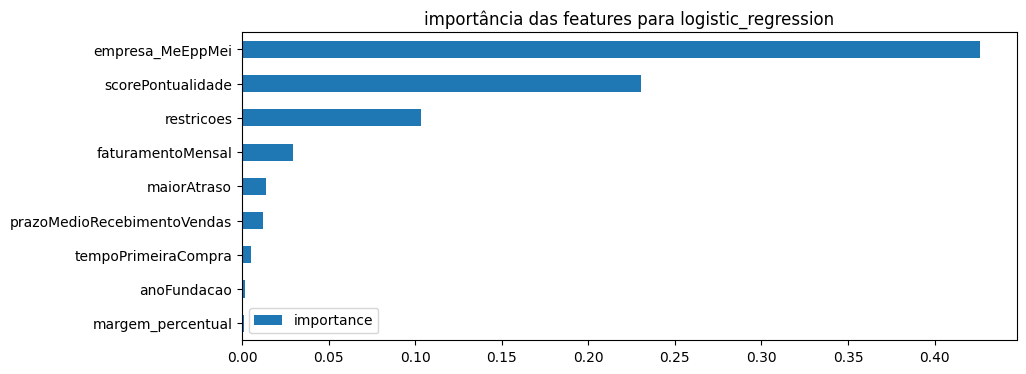

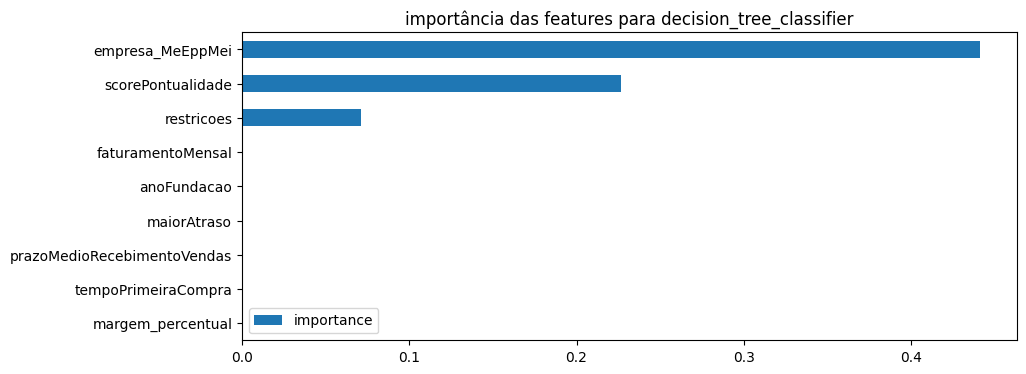

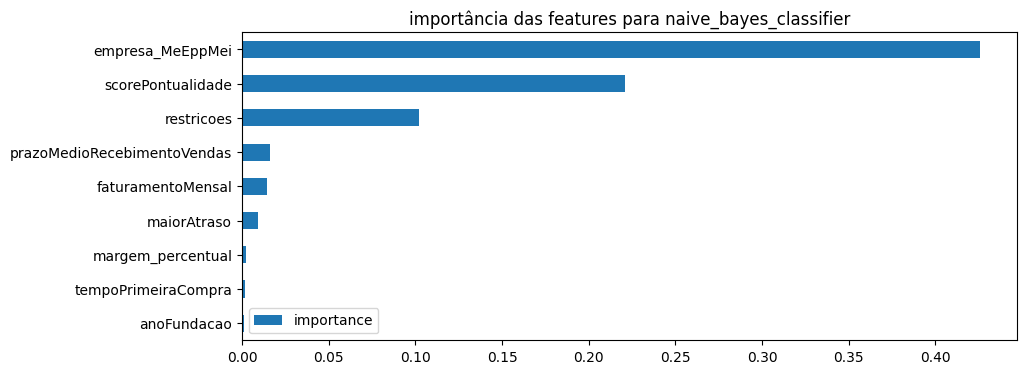

In [17]:
def plot_feature_importances(
		model: dict,
		X: pd.DataFrame,
		y: pd.DataFrame,
		) -> None:
	importances = permutation_importance(model['estimator'], X, y, n_repeats=10)
	table = pd.DataFrame(importances.importances_mean, index=X.columns, columns=['importance'])
	table.sort_values(by='importance', ascending=True, inplace=True)
	table.plot.barh(figsize=(10, 3+int(table.shape[0]/6)))
	plt.title(f'importância das features para {model["description"]}')
	plt.show()

for model in models:
	plot_feature_importances(model, data_train, targets_train)


### Conclusão

⭐ nota
<div style="color:#222200;background-color:#FFFFBB;padding:10px;"><table style="border:0px solid;width:100%">
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
o modelo escolhido, regressão logística, utilizou bem as features disponíveis para identificar o segmento dos clientes, apresentando uma acurácia de 99%
</td></tr></table></div>